In [1]:
from functools import partial
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analysis import load_sim_states, load_toml, get_vehicle_arrival_and_exits, display_and_save_animation
from tqdm import tqdm
from IPython.display import HTML

### Set-up config files and run with single seed

In [2]:
# Seed
SEED = 0

# File names for two crossings
config_file2 = "zebra_config_2crossings.toml"
outfile2 = "sim_states_2crossings.json"

# File names for three crossings
config_file3 = "zebra_config_3crossings.toml"
outfile3 = "sim_states_3crossings.json"

In [3]:
%%writefile $config_file2
road_length = 600
zebra_crossings = [180, 440]
pelican_crossings = []
max_acceleration = 4.0
max_deceleration = 3.0
crossing_time = 8000
pelican_wait_time = 5000
pelican_go_time = 5000
max_speed = 13.41

[simulation]
run_time = 1800_000
num_pedestrians = 500
num_vehicles = 500
vehicle_arrival_rate = 0.2
pedestrian_arrival_rate = 0.1

Overwriting zebra_config_2crossings.toml


In [4]:
%%writefile $config_file3
road_length = 600
zebra_crossings = [180, 300, 440]
pelican_crossings = []
max_acceleration = 4.0
max_deceleration = 3.0
crossing_time = 8000
pelican_wait_time = 5000
pelican_go_time = 5000
max_speed = 13.41

[simulation]
run_time = 1800_000
num_pedestrians = 500
num_vehicles = 500
vehicle_arrival_rate = 0.2
pedestrian_arrival_rate = 0.1

Overwriting zebra_config_3crossings.toml


In [5]:
# Make "call" partial fn for convenience, returns failures unlike "!"
call = partial(subprocess.check_call, shell=False, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

In [6]:
# Run the simulations
call(["cargo", "run", "--", "--config_file", config_file2, "--outfile", outfile2, "--seed", str(SEED)])
call(["cargo", "run", "--", "--config_file", config_file3, "--outfile", outfile3, "--seed", str(SEED)])

0

In [7]:
# This is a debug case
call(["cargo", "run", "--", "--config_file", config_file3, "--outfile", outfile3, "--seed", str(12)])

0

In [8]:
# Load zebra toml and outfiles
zebra_toml2 = load_toml(config_file2)
states2 = load_sim_states(outfile2)
zebra_toml3 = load_toml(config_file3)
states3 = load_sim_states(outfile3)

In [9]:
# Get dataframes for two and three crossing versions
df2 = get_vehicle_arrival_and_exits(states2)
df3 = get_vehicle_arrival_and_exits(states3)

> Mean transit times:
Two crossings:   54.603s
Three crossings: 55.442s
> Median transit times:
Two crossings:   53.113s
Three crossings: 52.980s


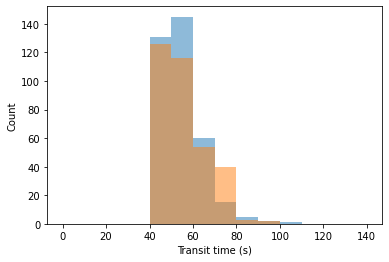

In [10]:
# Plot hists, compare means and medians
bins = np.arange(0, 150, 10)
alpha = 0.5
plt.hist(df2["transit"], bins=bins, alpha=alpha)
plt.hist(df3["transit"], bins=bins, alpha=alpha)
plt.ylabel("Count")
plt.xlabel("Transit time (s)")
mean2, median2 = df2["transit"].mean(), df2["transit"].median()
mean3, median3 = df3["transit"].mean(), df3["transit"].median()
print(f"> Mean transit times:")
print(f"Two crossings:   {mean2:.3f}s")
print(f"Three crossings: {mean3:.3f}s")
print(f"> Median transit times:")
print(f"Two crossings:   {median2:.3f}s")
print(f"Three crossings: {median3:.3f}s")

In [11]:
# Display and save animation
html = display_and_save_animation(states3, zebra_toml3, "zebra_3crossings.gif", frame_limit=20000, write=False)

display(HTML(html))
plt.close()

### Set-up and get averages across multiple runs

In [12]:
# Number of simulations to aggregate
N_SEEDS = 100

# 2 crossings
dfs2 = []
for i in tqdm(range(N_SEEDS)):
    call([
        "cargo", "run", "--",
        "--config_file", config_file2,
        "--outfile", outfile2,
        "--seed", str(i)
    ])
    zebra_toml2 = load_toml(config_file2)
    states2 = load_sim_states(outfile2)
    df2 = get_vehicle_arrival_and_exits(states2)
    df2["seed"] = i
    dfs2.append(df2)
dfs2 = pd.concat(dfs2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.43it/s]


In [13]:
# 3 crossings
dfs3 = []
for i in tqdm(range(N_SEEDS)):
    call([
        "cargo", "run", "--",
        "--config_file", config_file3,
        "--outfile", outfile3,
        "--seed", str(i)
    ])
    zebra_toml3 = load_toml(config_file3)
    states3 = load_sim_states(outfile3)
    df3 = get_vehicle_arrival_and_exits(states3)
    df3["seed"] = i
    dfs3.append(df3)
dfs3 = pd.concat(dfs3)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


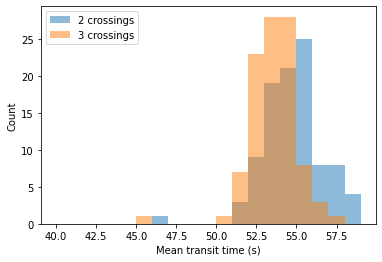

In [14]:
# Compare means
# Means
means2 = dfs2.groupby("seed")["transit"].mean()
means3 = dfs3.groupby("seed")["transit"].mean()

alpha = 0.5
bins = np.arange(40, 60, 1)
plt.hist(means2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(means3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.ylabel("Count")
plt.xlabel("Mean transit time (s)")
plt.show()

In [15]:
from scipy.stats import ttest_ind, mannwhitneyu

print(f"Difference in mean of means: {np.mean(means2)-np.mean(means3):.3f}s")
print(ttest_ind(means2, means3))
print(mannwhitneyu(means2, means3))

Difference in mean of means: 1.261s
Ttest_indResult(statistic=5.127926438255665, pvalue=6.951357901569471e-07)
MannwhitneyuResult(statistic=7115.0, pvalue=2.3845978820685445e-07)


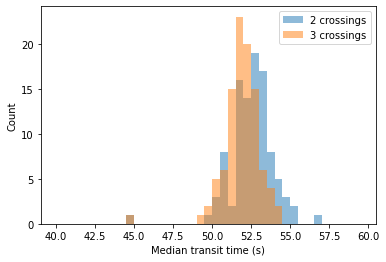

In [16]:
# Compare medians
medians2 = dfs2.groupby("seed")["transit"].quantile(0.5)
medians3 = dfs3.groupby("seed")["transit"].quantile(0.5)

bins = np.arange(40, 60, 0.5)
plt.hist(medians2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(medians3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.ylabel("Count")
plt.xlabel("Median transit time (s)")
plt.show()

In [17]:
from scipy.stats import ttest_ind, mannwhitneyu

print(f"Difference in mean of medians: {np.mean(medians2)-np.mean(medians3):.3f}s")
print(ttest_ind(medians2, medians3))
print(mannwhitneyu(medians2, medians3))

Difference in mean of medians: 0.647s
Ttest_indResult(statistic=3.4528623289806237, pvalue=0.000678203357831627)
MannwhitneyuResult(statistic=6677.0, pvalue=4.197223331177988e-05)


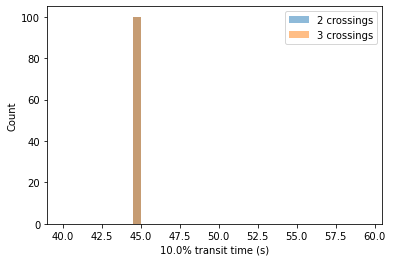

In [20]:
# Compare top 10%
q = 0.1
p5_2 = dfs2.groupby("seed")["transit"].quantile(q)
p5_3 = dfs3.groupby("seed")["transit"].quantile(q)

bins = np.arange(40, 60, 0.5)
plt.hist(p5_2, bins=bins, alpha=alpha, label="2 crossings")
plt.hist(p5_3, bins=bins, alpha=alpha, label="3 crossings")
plt.legend()
plt.ylabel("Count")
plt.xlabel(f"{q:.1%} transit time (s)")
plt.show()